In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.metrics import mean_absolute_error
from mbeml.plotting import (
    color_dict,
    marker_dict,
    interpolation_plot,
    interpolation_scatter,
    isomer_legend,
    core_legend,
)

In [3]:
plt.style.use("mbeml.mbeml")

In [4]:
data_dir = Path("../../data/")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")

model_dir = Path("../../models/")

In [5]:
A = "methanol"
B = "hydrogencyanide"
C = "hydrogenisocyanide"
df_heteroleptic = pd.read_csv(data_dir / "composition_test_data.csv")

In [6]:
df_homoleptic = pd.read_csv(data_dir / "training_data.csv")
df_homoleptic["name"] = df_homoleptic["name"].str.replace(
    "[C+]#[NH-]", "hydrogenisocyanide", regex=False
)
df_homoleptic = df_homoleptic[
    (
        df_homoleptic["name"].str.contains("_".join([A] * 6), regex=False)
        | df_homoleptic["name"].str.contains("_".join([B] * 6), regex=False)
        | df_homoleptic["name"].str.contains("_".join([C] * 6), regex=False)
    )
]
assert len(df_homoleptic) == 24
df_full = pd.concat([df_homoleptic, df_heteroleptic])

In [7]:
ligs = np.stack(df_full["name"].apply(lambda x: x.split("_")[2:]).values)
N_A = np.sum(ligs == A, axis=-1, keepdims=True)
N_B = np.sum(ligs == B, axis=-1, keepdims=True)
N_C = np.sum(ligs == C, axis=-1, keepdims=True)

cores = df_full[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
unique_cores = np.unique(cores)

In [8]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.ORBITALS
    is_nn: bool = False
    prediction = np.zeros([len(df_full), 1])

In [9]:
krr_experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
]
nn_experiments = [
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]
experiments = krr_experiments + nn_experiments

In [10]:
for experiment in experiments:
    X, _ = data_prep(df_full, experiment.features, experiment.target, experiment.is_nn)
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        # First element because uncertainty is not needed
        experiment.prediction = model.predict(X, verbose=0)[0]
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        experiment.prediction = model.predict(X)

2024-04-01 20:40:01.512962: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
def XY_curve(core, X, Y):
    indices = []
    x_vec = []
    for i in range(0, 6):
        if i == 2:
            # First cis
            ind_cis = np.where(
                (cores == core) & (ligs == [X, X, X, Y, X, Y]).all(axis=1)
            )[0]
            # then trans
            ind_trans = np.where(
                (cores == core) & (ligs == [X] * 4 + [Y] * 2).all(axis=1)
            )[0]
            inds = [ind_cis[0], ind_trans[0]]
        elif i == 3:
            # First fac
            ind_fac = np.where(
                (cores == core)
                & (
                    (ligs == [X, X, Y, Y, X, Y]).all(axis=1)
                    | (ligs == [X, X, Y, Y, Y, X]).all(axis=1)
                    | (ligs == [Y, Y, X, X, Y, X]).all(axis=1)
                    | (ligs == [Y, Y, X, X, X, Y]).all(axis=1)
                )
            )[0]
            # then mer
            ind_mer = np.where(
                (cores == core)
                & (
                    (ligs == [X] * 3 + [Y] * 3).all(axis=1)
                    | (ligs == [Y] * 3 + [X] * 3).all(axis=1)
                )
            )[0]
            inds = [ind_fac[0], ind_mer[0]]
        elif i == 4:
            # First cis
            ind_cis = np.where(
                (cores == core) & (ligs == [Y, Y, Y, X, Y, X]).all(axis=1)
            )[0]
            # then trans
            ind_trans = np.where(
                (cores == core) & (ligs == [Y] * 4 + [X] * 2).all(axis=1)
            )[0]
            inds = [ind_cis[0], ind_trans[0]]
        else:
            inds = np.where(
                (cores == core)
                & (
                    (ligs == [X] * (6 - i) + [Y] * i).all(axis=1)
                    | (ligs == [Y] * i + [X] * (6 - i)).all(axis=1)
                )
            )[0]
        indices.extend(inds)
        x_vec.extend(i * np.ones_like(inds))
    return indices, x_vec


def interp_curve(core):
    indices = []
    x_vec = []

    for X, Y, i0 in [(A, B, 0), (B, C, 6), (C, A, 12)]:
        inds, xs = XY_curve(core, X, Y)
        indices.extend(inds)
        x_vec.extend([i0 + xi for xi in xs])
    # Add the final A (closing the loop)
    indices.append(indices[0])
    x_vec.append(18)

    return indices, np.array(x_vec)

In [12]:
label_dict = {
    core: f"{core[:2].capitalize()}({'I'*int(core[-1])})" for core in unique_cores
}

alpha = 0.8
alpha_cis = 0.4
alpha_trans = alpha
scatter_kwargs = {
    "clip_on": False,
    "zorder": 3,
    "alpha": alpha,
    "s": 25,
    "edgecolors": "none",
}
plot_kwargs = {"linewidth": 0.9, "zorder": 0.5}


def base_plot(
    cores_to_plot,
    experiments,
    target=TargetProperty.ORBITALS,
    lowerlim=-50,
    upperlim=85,
):
    key = target.full_name()[0]

    fig = plt.figure(figsize=(3.33, 4.44))
    axes = fig.subplots(
        nrows=3,
        sharex=True,
        sharey=True,
        gridspec_kw=dict(
            hspace=0.0,
            left=0.16,
            right=0.90,
            top=0.97,
            bottom=0.06,
        ),
    )

    ax = axes[0]
    # Set all the ticks/labels/annotations of the plot
    for ax, label in zip(axes, ["standard-RACs", "two-body", "three-body"]):
        ax.axvline(6, color="k", linestyle="--", zorder=0.0)
        ax.axvline(12, color="k", linestyle="--", zorder=0.0)
        ax.axhline(0, color="k", linewidth=0.5, zorder=0.0)
        ax.set_ylabel("HOMO$_\mathrm{LS}$ (eV)")
        ax.yaxis.set_ticks_position("both")
        # Label the right side with the model type
        ax.text(
            19,
            0.5 * (lowerlim + upperlim),
            label,
            rotation=90,
            fontsize=9,
            verticalalignment="center",
        )
    # The next few options are just set on one ax element
    # because those properties are shared anyway
    ax.set_xlim(0, 18)
    ax.set_ylim(lowerlim, upperlim)
    ax.set_xticks(range(19), minor=True)
    ax.set_xticks([0, 6, 12, 18])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.set_xticklabels(
        [
            "(MeOH)$_6$",
            "(NCH)$_6$",
            "(CNH)$_6$",
            "(MeOH)$_6$",
        ],
    )

    # Plot scatters and lines
    for ax, experiment in zip(axes, experiments):
        for core in cores_to_plot:
            indices, x = interp_curve(core)
            interpolation_scatter(
                ax,
                x,
                df_full.iloc[indices][key],
                color=color_dict[core[:-1]],
                marker=marker_dict[core[-1]],
                alpha_cis=alpha_cis,
                alpha_trans=alpha_trans,
                **scatter_kwargs,
            )
            interpolation_plot(
                ax,
                x,
                experiment.prediction[indices][:, 0],
                color=color_dict[core[:-1]],
                alpha_cis=alpha_cis,
                alpha_trans=alpha_trans,
                **plot_kwargs,
            )
    return fig, axes


def four_metal_plot(cores_to_plot, experiments, **kwargs):
    fig, axes = base_plot(cores_to_plot, experiments, **kwargs)
    # Add Legend
    # First for cores
    ax = axes[0]
    handles = []
    labels = []
    for core in cores_to_plot:
        p = ax.scatter(
            [],
            [],
            color=color_dict[core[:2]],
            marker=marker_dict[core[-1]],
            **dict(scatter_kwargs, clip_on=True),
        )
        handles.append(p)
        labels.append(label_dict[core])
    ax.legend(
        handles,
        labels,
        loc="upper left",
        ncols=4,
        markerscale=0.95,
        bbox_to_anchor=(0.0, 1.10),
        handlelength=1.3,
        handletextpad=0.2,
        columnspacing=0.5,
    )

    # Then for isomers
    isomer_legend(axes[1])
    return fig, axes


def two_metal_plot(cores_to_plot, experiments, **kwargs):
    fig, axes = base_plot(cores_to_plot, experiments, **kwargs)
    # Add Legend
    # First for cores
    ax = axes[0]
    handles = []
    labels = []
    for core in cores_to_plot:
        p = ax.scatter(
            [],
            [],
            color=color_dict[core[:2]],
            marker=marker_dict[core[-1]],
            **dict(scatter_kwargs, clip_on=True),
        )
        handles.append(p)
        labels.append(label_dict[core])
    ax.legend(
        handles,
        labels,
        loc="upper left",
        markerscale=0.95,
        handlelength=1.3,
        handletextpad=0.2,
    )

    # Then for isomers
    isomer_legend(axes[1])
    return fig, axes

# Just target data

In [57]:
def target_data_plot(ls_key, ylim=(-25, -5), base_label="HOMO"):
    fig, axes = plt.subplots(
        figsize=(6.66, 0.8 * 3.33),
        ncols=2,
        gridspec_kw=dict(
            hspace=0.0,
            wspace=0.25,
            left=0.08,
            right=0.95,
            top=0.95,
            bottom=0.08,
        ),
    )

    alpha = 0.6
    alpha_cis = 0.3
    alpha_trans = alpha
    scatter_kwargs = {
        "clip_on": False,
        "zorder": 3,
        "alpha": alpha,
        "s": 25,
        "edgecolors": "none",
    }

    hs_key = ls_key.replace("ls", "hs")
    for ax, key, ylabel in [
        (axes[0], ls_key, base_label + "$_\mathrm{LS}$ (eV)"),
        (axes[1], hs_key, base_label + "$_\mathrm{HS}$ (eV)"),
    ]:
        for core in unique_cores:
            indices, x = interp_curve(core)
            interpolation_scatter(
                ax,
                x,
                df_full.iloc[indices][key].values,
                color=color_dict[core[:-1]],
                marker=marker_dict[core[-1]],
                alpha_cis=alpha_cis,
                alpha_trans=alpha_trans,
                **scatter_kwargs,
            )
            interpolation_plot(
                ax,
                x,
                df_full.iloc[indices][key].values,
                color=color_dict[core[:-1]],
                alpha_cis=alpha_cis,
                alpha_trans=alpha_trans,
                **plot_kwargs,
            )
        ax.axvline(6, color="k", linestyle="--", zorder=0.0)
        ax.axvline(12, color="k", linestyle="--", zorder=0.0)
        ax.set_ylabel(ylabel)
        ax.yaxis.set_ticks_position("both")
        ax.set_xlim(0, 18)
        ax.set_ylim(*ylim)
        ax.set_xticks(range(19), minor=True)
        ax.set_xticks([0, 6, 12, 18])
        ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.set_xticklabels(
            [
                "(MeOH)$_6$",
                "(NCH)$_6$",
                "(CNH)$_6$",
                "(MeOH)$_6$",
            ],
        )
        legend = core_legend(
            ax,
            legend_kwargs={
                "handletextpad": 0.2,
                "columnspacing": 0.4,
                "loc": "upper left",
                "bbox_to_anchor": (0.01, 1.07),
            },
        )
        isomer_legend(
            ax,
            alpha_cis=alpha_cis,
            alpha_trans=alpha_trans,
            legend_kwargs={"loc": "center left"},
        )
        ax.add_artist(legend)
    return fig, axes

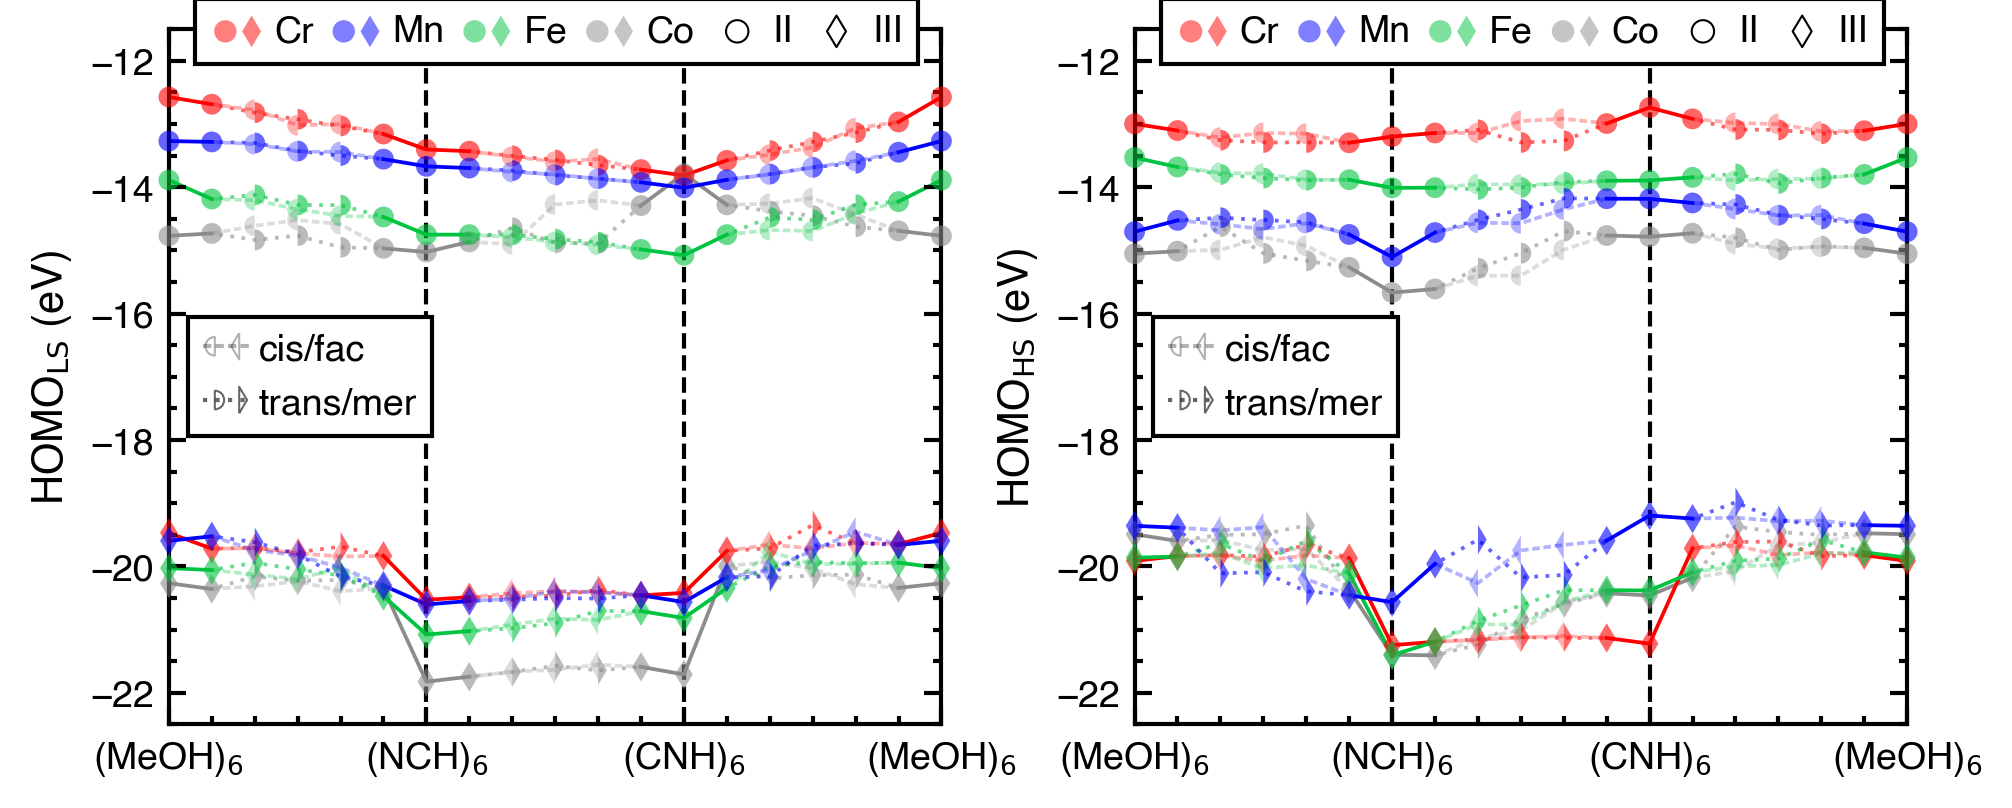

In [58]:
fig, _ = target_data_plot(ls_key="energetic_homo_ls_eV", ylim=(-22.5, -11.5))

fig.savefig("plots/interpolation_plot_homo.pdf")

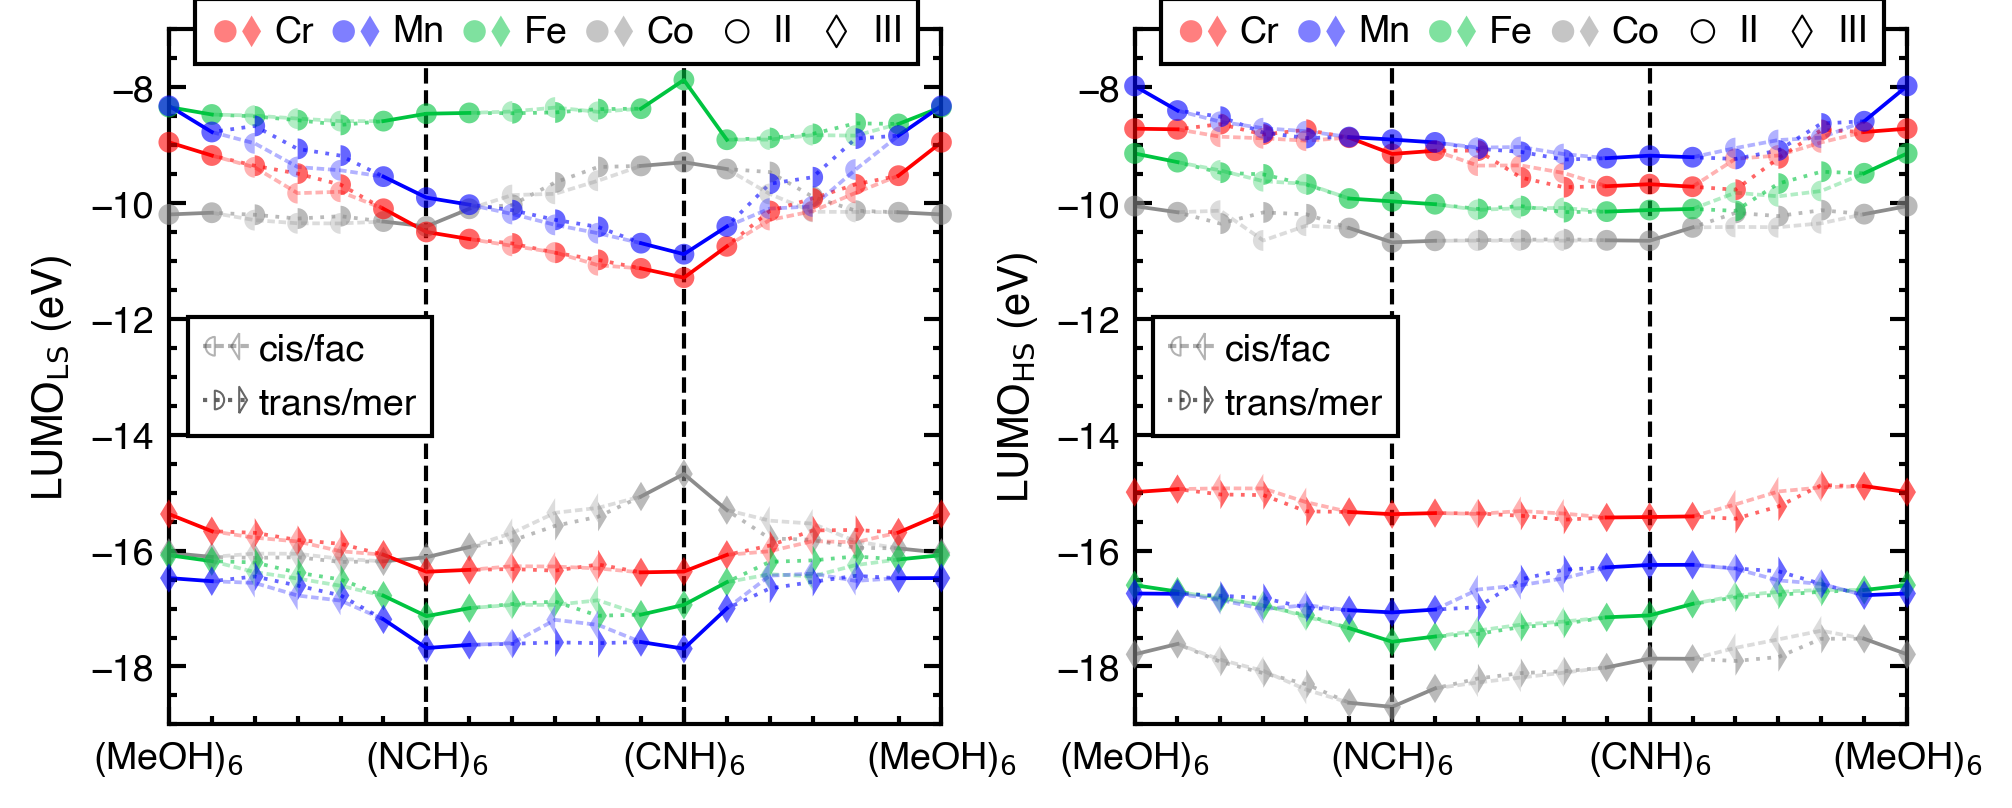

In [61]:
fig, _ = target_data_plot(
    ls_key="energetic_lumo_ls_eV", ylim=(-19.0, -7.0), base_label="LUMO"
)

fig.savefig("plots/interpolation_plot_lumo.pdf")

# KRR

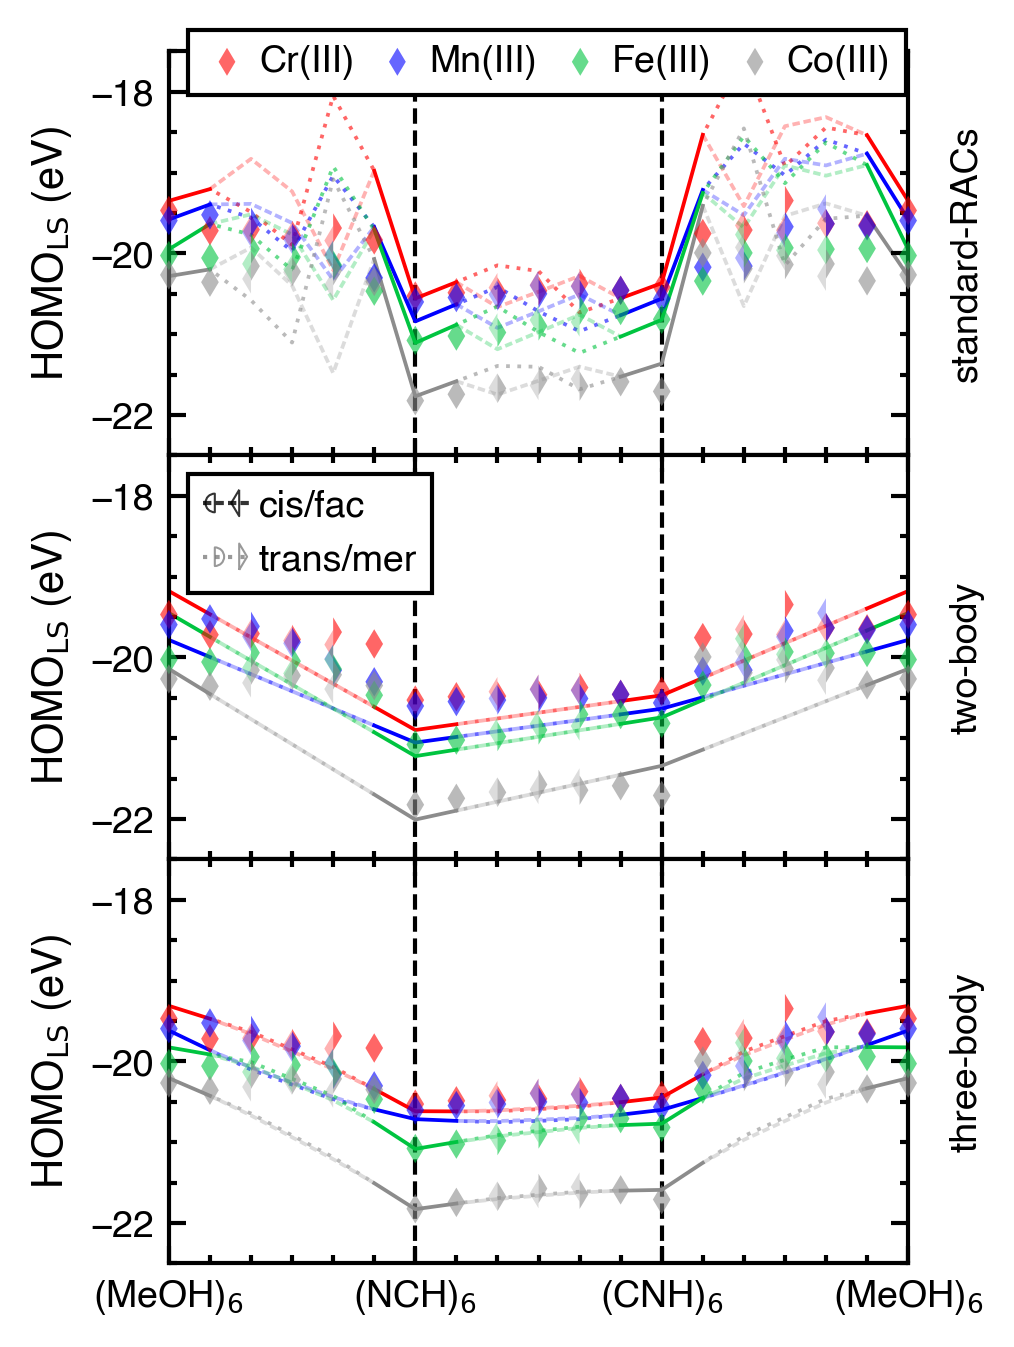

In [13]:
fig, _ = four_metal_plot(
    ["cr3", "mn3", "fe3", "co3"], krr_experiments, lowerlim=-22.5, upperlim=-17.5
)
# fig.savefig("plots/interpolation_plot_homo_ls_krr_1.pdf")

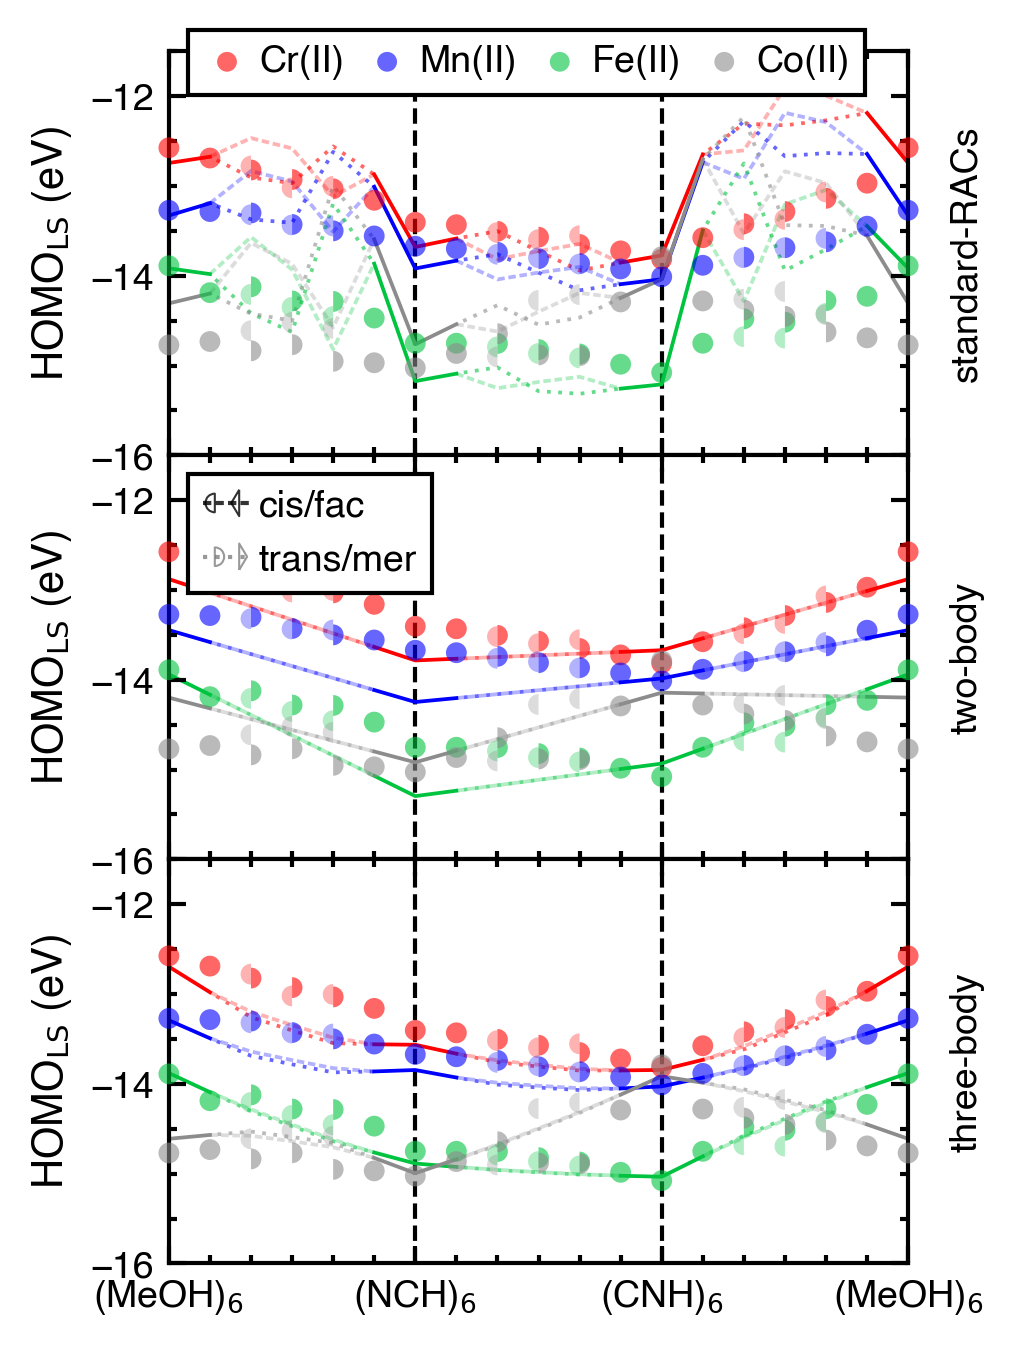

In [14]:
fig, _ = four_metal_plot(
    ["cr2", "mn2", "fe2", "co2"], krr_experiments, lowerlim=-16.0, upperlim=-11.5
)

# NN

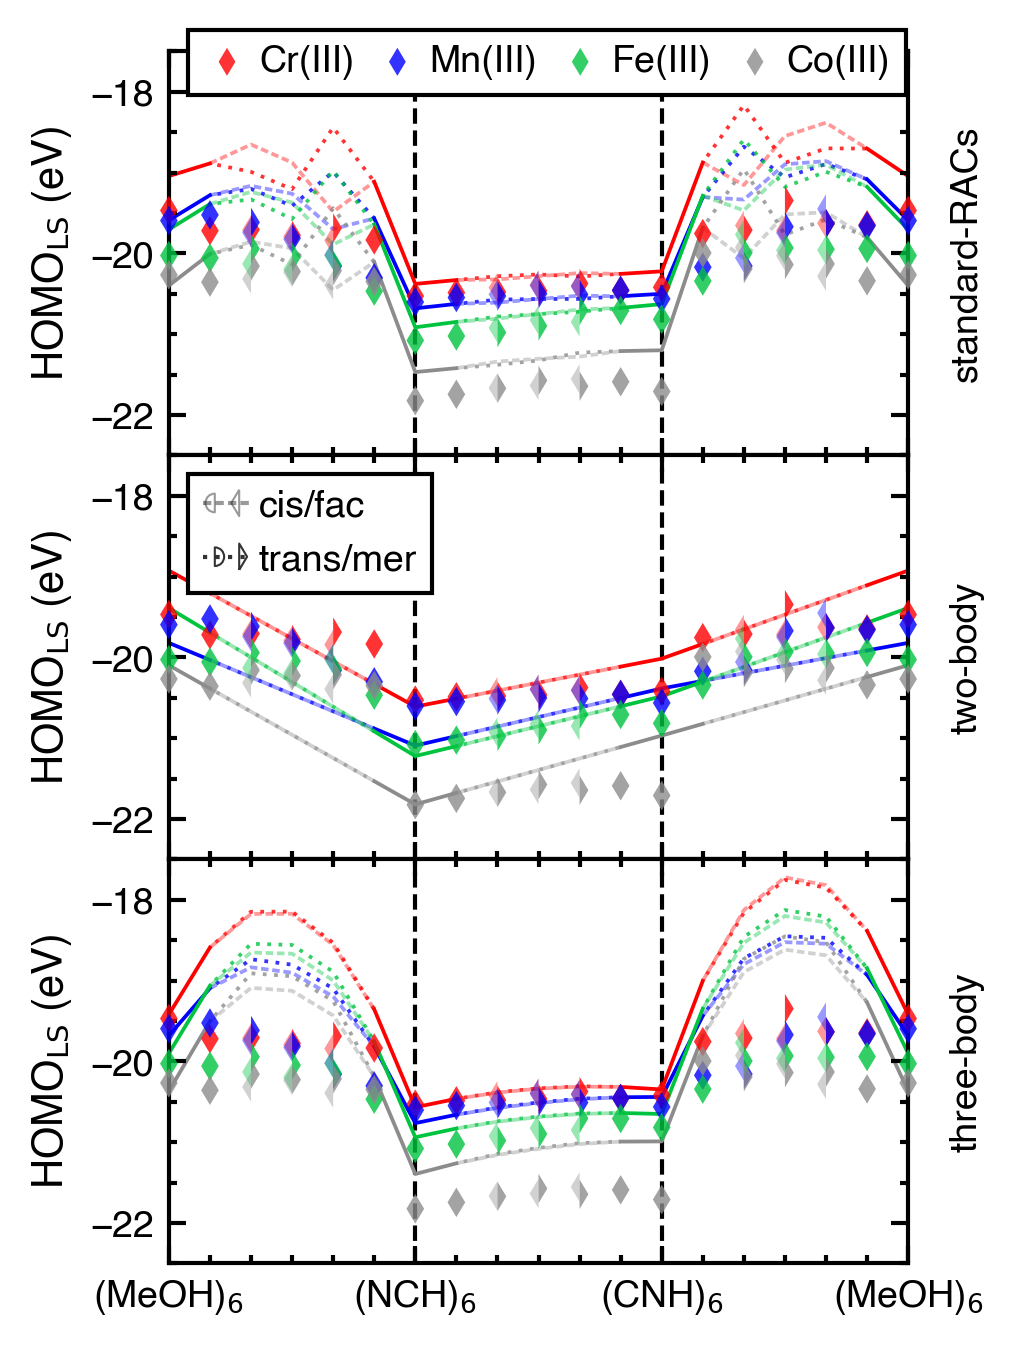

In [16]:
fig, _ = four_metal_plot(
    ["cr3", "mn3", "fe3", "co3"], nn_experiments, lowerlim=-22.5, upperlim=-17.5
)
# fig.savefig("plots/interpolation_plot_sse_nn_1.pdf")

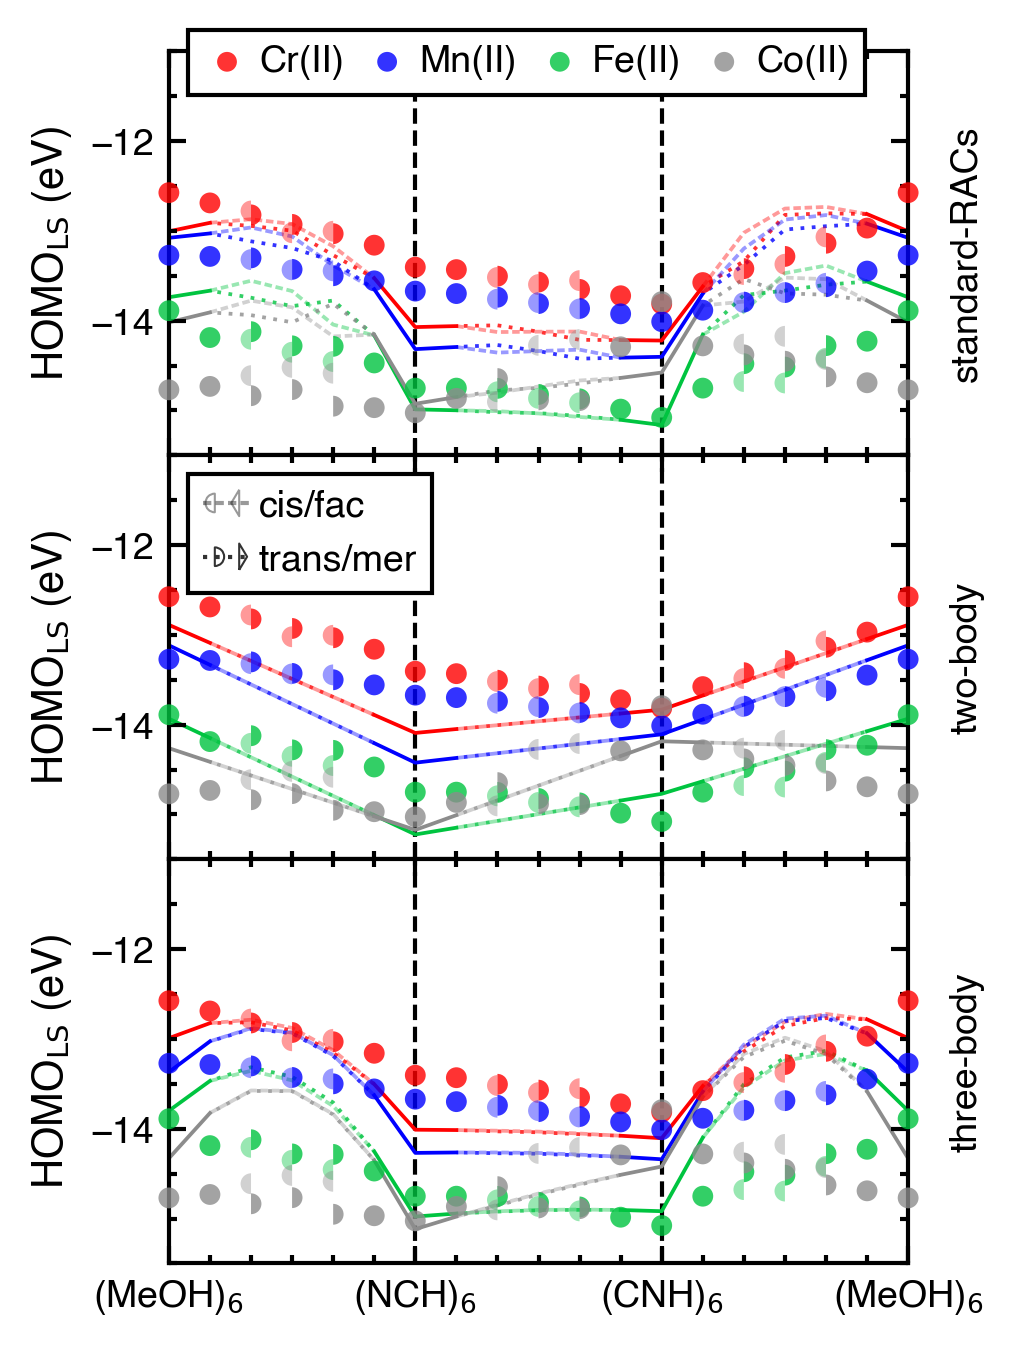

In [17]:
fig, _ = four_metal_plot(
    ["cr2", "mn2", "fe2", "co2"], nn_experiments, lowerlim=-15.5, upperlim=-11
)
# fig.savefig("plots/interpolation_plot_sse_nn_2.pdf")

# Average isomer splitting

In [24]:
def get_isomer_splits(experiment):
    isomer_splits = np.zeros([8 * 3, 3, 4])
    for i, core in enumerate(unique_cores):
        for j, (a, b) in enumerate([(A, B), (B, C), (C, A)]):
            indices, _ = XY_curve(core, a, b)
            isomer_splits[i * 3 + j, 0] = (
                experiment.prediction[indices[2]] - experiment.prediction[indices[3]]
            )
            isomer_splits[i * 3 + j, 1] = (
                experiment.prediction[indices[4]] - experiment.prediction[indices[5]]
            )
            isomer_splits[i * 3 + j, 2] = (
                experiment.prediction[indices[6]] - experiment.prediction[indices[7]]
            )
    return isomer_splits

In [30]:
get_isomer_splits(krr_experiments[0])[0]

array([[ 0.78738851,  1.0777747 ,  1.12103413,  1.08032399],
       [ 0.63282636,  0.903829  ,  0.49832465,  0.48348652],
       [-1.57906045, -2.10309447, -0.55299094, -0.53270435]])

In [38]:
def get_curvatures(experiment):
    curvatures = np.zeros([8 * 3, 4])
    for i, core in enumerate(unique_cores):
        for j, (a, b) in enumerate([(A, B), (B, C), (C, A)]):
            ind_a = np.where((cores == core) & (ligs == [a] * (6)).all(axis=1))[0]
            ind_b = np.where((cores == core) & (ligs == [b] * (6)).all(axis=1))[0]
            indices, _ = XY_curve(core, a, b)
            assert indices[0] == ind_a
            curvatures[i * 3 + j] = 0.5 * (
                experiment.prediction[indices[1]]
                - (
                    5 / 6 * experiment.prediction[ind_a]
                    + 1 / 6 * experiment.prediction[ind_b]
                )
            ) + 0.5 * (
                experiment.prediction[indices[8]]
                - (
                    1 / 6 * experiment.prediction[ind_a]
                    + 5 / 6 * experiment.prediction[ind_b]
                )
            )
    return curvatures

In [40]:
get_curvatures(krr_experiments[0])[0]

array([0.63943904, 0.77532774, 0.03737495, 0.08853993])

In [46]:
print(
    "MAD of standard-RACs KRR isomer split",
    f"{np.mean(abs(get_isomer_splits(krr_experiments[0]))[:, :, :2]):.3f}",
)
print(
    "MAD of standard-RACs isomer split",
    f"{np.mean(abs(get_isomer_splits(nn_experiments[0]))[:, :, :2]):.3f}",
)
print(
    "MAD of two-body KRR isomer split",
    f"{np.mean(abs(get_isomer_splits(krr_experiments[1]))[:, :, :2]):.3f}",
)
print(
    "MAD of two-body NN isomer split",
    f"{np.mean(abs(get_isomer_splits(nn_experiments[1]))[:, :, :2]):.3f}",
)
print(
    "MAD of three-body KRR isomer split",
    f"{np.mean(abs(get_isomer_splits(krr_experiments[2]))[:, :, :2]):.3f}",
)
print(
    "MAD of three-body NN isomer split",
    f"{np.mean(abs(get_isomer_splits(nn_experiments[2]))[:, :, :2]):.3f}",
)

MAD of standard-RACs KRR isomer split 0.642
MAD of standard-RACs isomer split 0.249
MAD of two-body KRR isomer split 0.000
MAD of two-body NN isomer split 0.000
MAD of three-body KRR isomer split 0.032
MAD of three-body NN isomer split 0.038


In [47]:
print(
    "MAD of standard-RACs KRR curvature",
    f"{np.mean(abs(get_curvatures(krr_experiments[0]))[:, :2]):.3f}",
)
print(
    "MAD of standard-RACs curvature",
    f"{np.mean(abs(get_curvatures(nn_experiments[0]))[:, :2]):.3f}",
)
print(
    "MAD of two-body KRR curvature",
    f"{np.mean(abs(get_curvatures(krr_experiments[1]))[:, :2]):.3f}",
)
print(
    "MAD of two-body NN curvature",
    f"{np.mean(abs(get_curvatures(nn_experiments[1]))[:, :2]):.3f}",
)
print(
    "MAD of three-body KRR curvature",
    f"{np.mean(abs(get_curvatures(krr_experiments[2]))[:, :2]):.3f}",
)
print(
    "MAD of three-body NN curvature",
    f"{np.mean(abs(get_curvatures(nn_experiments[2]))[:, :2]):.3f}",
)

MAD of standard-RACs KRR curvature 0.610
MAD of standard-RACs curvature 0.438
MAD of two-body KRR curvature 0.000
MAD of two-body NN curvature 0.000
MAD of three-body KRR curvature 0.074
MAD of three-body NN curvature 0.550


# Per composition errors

In [107]:
def metric_per_composition(experiments, metric, transformation=None):
    if transformation is None:
        transformation = lambda x: x
    metrics = {}
    # Homoleptic (not part of the test set)
    ind_homo = []
    ind_5p1 = []
    ind_4p2 = []
    ind_3p3 = []
    for core in unique_cores:
        for a, b in [(A, B), (B, C), (C, A)]:
            indices, _ = XY_curve(core, a, b)
            ind_homo.append(indices[0])
            ind_5p1.extend([indices[1], indices[8]])
            ind_4p2.extend([indices[2], indices[3], indices[6], indices[7]])
            ind_3p3.extend([indices[4], indices[5]])

    for experiment in experiments:
        metrics_row = {}
        for subset, inds in [
            ("homoleptic", ind_homo),
            ("5+1", ind_5p1),
            ("4+2", ind_4p2),
            ("3+3", ind_3p3),
        ]:
            metrics_row[subset] = metric(
                transformation(experiment.prediction[inds]),
                transformation(
                    df_full.iloc[inds][TargetProperty.ORBITALS.full_name()].values
                ),
            )
        metrics[experiment.name] = metrics_row

    return pd.DataFrame.from_dict(metrics, orient="index")

In [112]:
def homo_both(x):
    return x[:, :2]


def lumo_both(x):
    return x[:, 2:]


def gap_both(x):
    return x[:, 2:] - x[:, :2]

In [110]:
metric_per_composition(
    krr_experiments + nn_experiments, mean_absolute_error, transformation=homo_both
).round(2)

,homoleptic,5+1,4+2,3+3
krr_standard_racs,0.15,0.56,0.62,0.50
krr_two_body,0.25,0.27,0.29,0.28
krr_three_body,0.08,0.20,0.24,0.23
nn_standard_racs,0.39,0.53,0.58,0.56
nn_two_body,0.38,0.32,0.30,0.29
nn_three_body,0.33,0.56,0.83,0.93


In [113]:
metric_per_composition(
    krr_experiments + nn_experiments, mean_absolute_error, transformation=lumo_both
).round(2)

,homoleptic,5+1,4+2,3+3
krr_standard_racs,0.25,0.32,0.50,0.54
krr_two_body,0.37,0.31,0.31,0.30
krr_three_body,0.11,0.18,0.24,0.23
nn_standard_racs,0.46,0.44,0.49,0.53
nn_two_body,0.46,0.41,0.41,0.38
nn_three_body,0.49,0.44,0.45,0.43


In [111]:
metric_per_composition(
    krr_experiments + nn_experiments, mean_absolute_error, transformation=gap_both
).round(2)

,homoleptic,5+1,4+2,3+3
krr_standard_racs,0.25,0.47,0.49,0.37
krr_two_body,0.38,0.34,0.35,0.32
krr_three_body,0.11,0.23,0.27,0.25
nn_standard_racs,0.52,0.52,0.52,0.43
nn_two_body,0.51,0.41,0.43,0.42
nn_three_body,0.53,0.74,0.97,1.06
